In [15]:
import datetime as dt
import pandas as pd
import numpy as np
from math import log, sqrt, exp
from scipy.optimize import minimize, brentq, least_squares, fsolve
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [16]:
df_swap = pd.read_excel("data/IR Data.xlsx", sheet_name = 'Swaption' , engine = "openpyxl", skiprows = 2)
df_swap = df_swap.iloc[0:15,0:13]
df_swap.iloc[:,2:] = df_swap.iloc[:,2:]/100
df_swap = df_swap.set_index(['Expiry', 'Tenor'])

df_swap

-200bps  -150bps  -100bps   -50bps   -25bps     ATM  +25bps  \
Expiry Tenor                                                                
1Y     1Y     0.91570  0.62030  0.44130  0.31224  0.26182  0.2250  0.2096   
       2Y     0.83270  0.61240  0.46570  0.35807  0.31712  0.2872  0.2712   
       3Y     0.73920  0.56870  0.44770  0.35745  0.32317  0.2978  0.2829   
       5Y     0.55190  0.44640  0.36510  0.30242  0.27851  0.2607  0.2498   
       10Y    0.41180  0.35040  0.30207  0.26619  0.25351  0.2447  0.2398   
5Y     1Y     0.67800  0.49090  0.38400  0.31485  0.29060  0.2726  0.2604   
       2Y     0.57880  0.46410  0.39033  0.33653  0.31531  0.2983  0.2856   
       3Y     0.53430  0.44440  0.38180  0.33437  0.31536  0.2998  0.2876   
       5Y     0.41990  0.36524  0.32326  0.29005  0.27677  0.2660  0.2573   
       10Y    0.34417  0.30948  0.28148  0.25954  0.25136  0.2451  0.2399   
10Y    1Y     0.55160  0.44320  0.37368  0.32259  0.30210  0.2854  0.2731   
       2Y     0.51170  0.42900  0.37078  0.32622  0.30800  0.2928  0.2809   
       3Y     0.48220  0.41430  0.36400  0.32439  0.30796  0.2940  0.2827   
       5Y     0.40550  0.35891  0.32181  0.29144  0.27857  0.2674  0.2580   
       10Y    0.33601  0.30509  0.27978  0.25926  0.25086  0.2437  0.2376   

              +50bps  +100bps  +150bps  +200bps  
Expiry Tenor                                     
1Y     1Y     0.2140   0.2434  0.27488  0.30297  
       2Y     0.2684   0.2851  0.31025  0.33523  
       3Y     0.2780   0.2877  0.30725  0.32833  
       5Y     0.2456   0.2512  0.26536  0.28165  
       10Y    0.2382   0.2425  0.25204  0.26355  
5Y     1Y     0.2532   0.2494  0.25320  0.25980  
       2Y     0.2765   0.2671  0.26540  0.26760  
       3Y     0.2782   0.2667  0.26200  0.26150  
       5Y     0.2502   0.2406  0.23570  0.23400  
       10Y    0.2356   0.2291  0.22490  0.22250  
10Y    1Y     0.2645   0.2561  0.25520  0.25780  
       2Y     0.2720   0.2612  0.25720  0.25710  
       3Y     0.2738   0.2618  0.25580  0.25370  
       5Y     0.2502   0.2387  0.23170  0.22800  
       10Y    0.2324   0.2244  0.21900  0.21560

# Calculate zero rates

In [17]:
disc_fac = pd.read_excel("data/IR Data.xlsx", sheet_name = 'OIS' , engine = "openpyxl", usecols = [0,1,2])
# Calculate discount factors
def convert_tenor(tenor):
    if "m" in tenor:
        return int(tenor.replace("m", "")) / 12  # Convert months to years
    elif "y" in tenor:
        return int(tenor.replace("y", ""))
    return None

disc_fac["Tenor_Years"] = disc_fac["Tenor"].apply(convert_tenor)
disc_fac["Discount_Factor"] = np.exp(-disc_fac["Rate"] * disc_fac["Tenor_Years"])
print(disc_fac)

#interpolate for the 0.5y periods
rate_interp = interp1d(disc_fac["Tenor_Years"], disc_fac["Rate"], kind='linear', fill_value="extrapolate")
df_interp = interp1d(disc_fac["Tenor_Years"], disc_fac["Discount_Factor"], kind='linear', fill_value="extrapolate")
tenor_intervals = np.arange(0.5, 20.5, 0.5)  # 0.5, 1.0, 1.5, ..., 10.0

# Interpolate rates and discount factors for these intervals
interpolated_rates = rate_interp(tenor_intervals)
interpolated_dfs = df_interp(tenor_intervals)
# Create a DataFrame to store the results
df_results = pd.DataFrame({
    'Tenor': tenor_intervals,
    'Rate': interpolated_rates,
    'Discount_Factor': interpolated_dfs
})

print(df_results)

   Tenor Product     Rate  Tenor_Years  Discount_Factor
0     6m     OIS  0.00250          0.5         0.998751
1     1y     OIS  0.00300          1.0         0.997004
2     2y     OIS  0.00325          2.0         0.993521
3     3y     OIS  0.00335          3.0         0.990000
4     4y     OIS  0.00350          4.0         0.986098
5     5y     OIS  0.00360          5.0         0.982161
6     7y     OIS  0.00400          7.0         0.972388
7    10y     OIS  0.00450         10.0         0.955997
8    15y     OIS  0.00500         15.0         0.927743
9    20y     OIS  0.00525         20.0         0.900325
10   30y     OIS  0.00550         30.0         0.847894
    Tenor      Rate  Discount_Factor
0     0.5  0.002500         0.998751
1     1.0  0.003000         0.997004
2     1.5  0.003125         0.995263
3     2.0  0.003250         0.993521
4     2.5  0.003300         0.991761
5     3.0  0.003350         0.990000
6     3.5  0.003425         0.988049
7     4.0  0.003500         0.98

# Calculate forward swap rates

In [18]:
forward_swap_df = pd.read_excel('data/swap_rates.xlsx', sheet_name = 'swap_rates')

#forward_swap_df = pd.DataFrame(forward_swap_df).set_index('Tenor')
# Drop the 'Unnamed: 0' column
forward_swap_df = forward_swap_df.drop(columns=['Unnamed: 0'])

# Rename columns
forward_swap_df.columns = ['1Y', '2Y', '3Y', '5Y', '10Y']

# Rename index
forward_swap_df.index = ['1Y', '5Y', '10Y']
forward_swap_df.index.name = "Expiry"
forward_swap_df.columns.name = "Tenor"
print(forward_swap_df)

Tenor         1Y        2Y        3Y        5Y       10Y
Expiry                                                  
1Y      0.032007  0.033259  0.034011  0.035255  0.038428
5Y      0.039274  0.040075  0.040072  0.041093  0.043634
10Y     0.042189  0.043116  0.044097  0.046249  0.053458


In [19]:
fwd_strikes = pd.read_excel("data/IR Data.xlsx", sheet_name = 'IRS' , engine = "openpyxl", usecols = [0,1,2])
print(fwd_strikes)

   Tenor Product    Rate
0     6m   LIBOR  0.0250
1     1y     IRS  0.0280
2     2y     IRS  0.0300
3     3y     IRS  0.0315
4     4y     IRS  0.0325
5     5y     IRS  0.0330
6     7y     IRS  0.0350
7    10y     IRS  0.0370
8    15y     IRS  0.0400
9    20y     IRS  0.0450
10   30y     IRS  0.0500


In [20]:
#calculate the bps
df_swap_vals = df_swap.iloc[0:15,0:13]
bps = []
for col in df_swap_vals.columns[:]:
    col_stripped = col[:-3]  # Remove 'bps' suffix if present
    try:
        bps.append(float(col_stripped) / 10000)  # Convert to float
    except ValueError:
        bps.append(0)  # Assign 0 for non-numeric columns like 'ATM'
bps = np.array(bps)
bps

array([-0.02  , -0.015 , -0.01  , -0.005 , -0.0025,  0.    ,  0.0025,
        0.005 ,  0.01  ,  0.015 ,  0.02  ])

In [21]:
# Black-Scholes formula
def blackscholescall(S, K, disc, sigma, T):
    d1 = (np.log(S / K) + (0.5 * sigma**2 * T)) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    blackscholesprice = disc*(S * norm.cdf(d1) - K * norm.cdf(d2))
    return blackscholesprice

def blackscholesput(S, K, disc, sigma, T):
    d1 = (np.log(S / K) + (0.5 * sigma**2 * T)) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    blackscholesprice = disc*(K * norm.cdf(-d2) - S * norm.cdf(-d1))
    return blackscholesprice

# Swaption price under Displaced-Diffusion model
def displaceddiffusioncall(S, K, disc, sigma, T, beta):
    adjusted_S = S / beta
    adjusted_K = K + ((1 - beta) / beta) * S
    adjusted_sigma = sigma * beta
    ddcallprice = blackscholescall(adjusted_S, adjusted_K, disc, adjusted_sigma, T)
    return ddcallprice

def displaceddiffusionput(S, K, disc, sigma, T, beta):
    adjusted_S = S / beta
    adjusted_K = K + ((1 - beta) / beta) * S
    adjusted_sigma = sigma * beta
    ddputprice = blackscholesput(adjusted_S, adjusted_K, disc, adjusted_sigma, T)
    return ddputprice

def ImpliedVolatility(S, K, disc, sigma, T, beta):
    """
    Calculate implied volatility based on market price

    Args:
    S(float): Forward price
    K(float): strike price
    T(float): time to expiration (in years)
    sigma(float): mid price between bid and offer

    Returns:
    Implied Volatility
    """
    if S <= K:
        price = displaceddiffusioncall(S, K, disc, sigma, T, beta)
        impliedVol = fsolve(lambda x: price -
                                    blackscholescall(S, K, disc, x, T),
                                    0.5)
    else:
        price = displaceddiffusionput(S, K, disc, sigma, T, beta)
        impliedVol = fsolve(lambda x: price -
                        blackscholesput(S, K, disc, x, T),
                            0.5)
    return impliedVol

# Calibration process
def DDcalibration(x, strikes, vols, S, disc, T):
    err = 0.0
    sigma = vols[5]
    for i, vol in enumerate(vols):
        implied_vol= ImpliedVolatility(S, strikes[i], disc, sigma, T, x)
        err += (vol - implied_vol)**2
    return err

In [22]:
expiries = ['1Y', '5Y', '10Y']
tenors = ['1Y', '2Y', '3Y', '5Y', '10Y']
DD_Sigma=pd.DataFrame(np.zeros((3,5)), index=expiries,columns=tenors)
DD_Beta=pd.DataFrame(np.zeros((3,5)), index=expiries,columns=tenors)
DD_Beta

,1Y,2Y,3Y,5Y,10Y
1Y,0.0,0.0,0.0,0.0,0.0
5Y,0.0,0.0,0.0,0.0,0.0
10Y,0.0,0.0,0.0,0.0,0.0


In [23]:
print(df_swap)

              -200bps  -150bps  -100bps   -50bps   -25bps     ATM  +25bps  \
Expiry Tenor                                                                
1Y     1Y     0.91570  0.62030  0.44130  0.31224  0.26182  0.2250  0.2096   
       2Y     0.83270  0.61240  0.46570  0.35807  0.31712  0.2872  0.2712   
       3Y     0.73920  0.56870  0.44770  0.35745  0.32317  0.2978  0.2829   
       5Y     0.55190  0.44640  0.36510  0.30242  0.27851  0.2607  0.2498   
       10Y    0.41180  0.35040  0.30207  0.26619  0.25351  0.2447  0.2398   
5Y     1Y     0.67800  0.49090  0.38400  0.31485  0.29060  0.2726  0.2604   
       2Y     0.57880  0.46410  0.39033  0.33653  0.31531  0.2983  0.2856   
       3Y     0.53430  0.44440  0.38180  0.33437  0.31536  0.2998  0.2876   
       5Y     0.41990  0.36524  0.32326  0.29005  0.27677  0.2660  0.2573   
       10Y    0.34417  0.30948  0.28148  0.25954  0.25136  0.2451  0.2399   
10Y    1Y     0.55160  0.44320  0.37368  0.32259  0.30210  0.2854  0.2731   

In [24]:
# Function to calculate PVBP
def calculate_pvbp(expiry_int, tenor_int, df_results):
    # Generate the payment periods (every 6 months)
    payment_periods = np.arange(expiry_int, expiry_int + tenor_int + 0.5, 0.5)

    # Interpolate discount factors for the payment periods
    discount_factors = np.interp(payment_periods, df_results["Tenor"], df_results["Discount_Factor"])

    # Calculate PVBP
    pvbp = 0.5 * 0.01 * np.sum(discount_factors)
    return pvbp

# Start optimization for DD

In [25]:
beta_initial_guess = [0.3]
for expiry in expiries:
    for tenor in tenors:
        swap_forward = forward_swap_df.loc[expiry,tenor]
        market_vol = df_swap.loc[(expiry, tenor), :].values
        strikes = swap_forward + bps
        expiry_int = int(expiry.strip()[:-1])
        tenor_int = int(tenor.strip()[:-1])
        print(tenor_int)

        # Calculate PVBP
        disc_factor = calculate_pvbp(expiry_int, tenor_int, df_results)
        #disc_factor = 0.5* sum(df_results.Discount_Factor[2*expiry_int:(expiry_int+tenor_int)*2])

        res = least_squares(
            lambda beta: DDcalibration(
                beta,
                strikes,
                market_vol,
                swap_forward,
                disc_factor,
                T= expiry_int
            ),
            beta_initial_guess,
            bounds=(0,2)
        )
        if res.success:
            DD_Sigma.loc[expiry, tenor] = market_vol[5]
            DD_Beta.loc[expiry, tenor] = res.x[0]
            print(f"Success: DD_Sigma[{tenor}][{expiry}] = {market_vol[5]}, DD_Beta[{tenor}][{expiry}] = {res.x[0]}")
        else:
            print(f"Optimization failed for expiry={expiry}, tenor={tenor}")

1
Success: DD_Sigma[1Y][1Y] = 0.225, DD_Beta[1Y][1Y] = 3.197284221385065e-08
2
Success: DD_Sigma[2Y][1Y] = 0.2872, DD_Beta[2Y][1Y] = 5.2178458807429604e-14
3
Success: DD_Sigma[3Y][1Y] = 0.2978, DD_Beta[3Y][1Y] = 2.4146828843895057e-13
5
Success: DD_Sigma[5Y][1Y] = 0.2607, DD_Beta[5Y][1Y] = 4.2125089482129786e-06
10
Success: DD_Sigma[10Y][1Y] = 0.2447, DD_Beta[10Y][1Y] = 6.654737410973031e-06
1
Success: DD_Sigma[1Y][5Y] = 0.2726, DD_Beta[1Y][5Y] = 1.3073987458610433e-11
2
Success: DD_Sigma[2Y][5Y] = 0.2983, DD_Beta[2Y][5Y] = 5.499250656820667e-08
3
Success: DD_Sigma[3Y][5Y] = 0.2998, DD_Beta[3Y][5Y] = 2.2771631568280735e-06
5
Success: DD_Sigma[5Y][5Y] = 0.266, DD_Beta[5Y][5Y] = 0.0001432599938804473
10
Success: DD_Sigma[10Y][5Y] = 0.2451, DD_Beta[10Y][5Y] = 0.055462210744784975
1
Success: DD_Sigma[1Y][10Y] = 0.2854, DD_Beta[1Y][10Y] = 1.3948572185723236e-07
2
Success: DD_Sigma[2Y][10Y] = 0.2928, DD_Beta[2Y][10Y] = 7.489268101996179e-06
3
Success: DD_Sigma[3Y][10Y] = 0.294, DD_Beta[3Y][1

In [26]:
DD_Sigma

,1Y,2Y,3Y,5Y,10Y
1Y,0.2250,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.2660,0.2451
10Y,0.2854,0.2928,0.2940,0.2674,0.2437


In [27]:
DD_Beta

,1Y,2Y,3Y,5Y,10Y
1Y,3.197284e-08,5.217846e-14,2.414683e-13,0.000004,0.000007
5Y,1.307399e-11,5.499251e-08,2.277163e-06,0.000143,0.055462
10Y,1.394857e-07,7.489268e-06,8.154931e-05,0.000001,0.001745


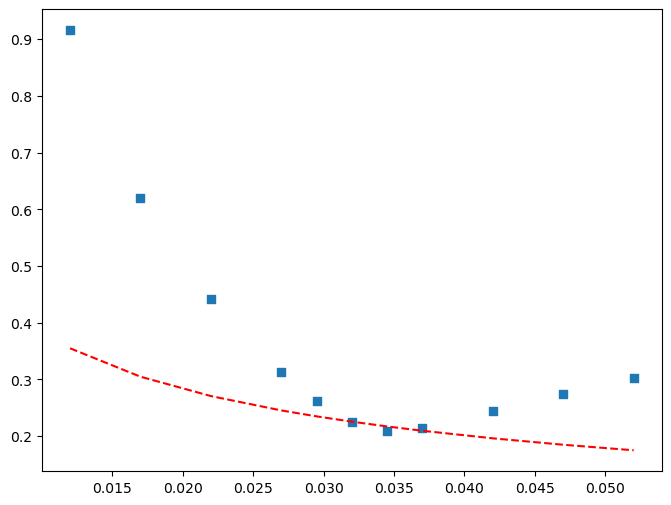

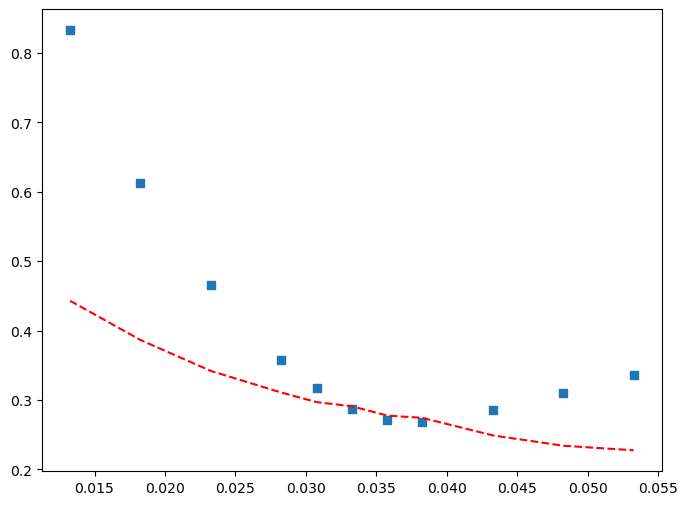

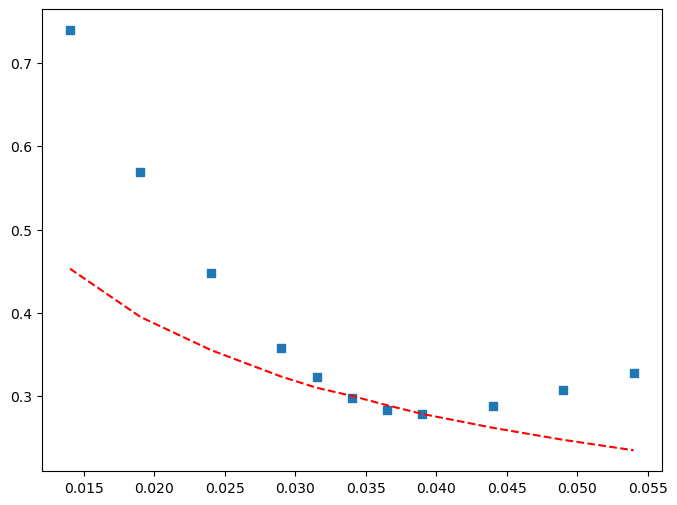

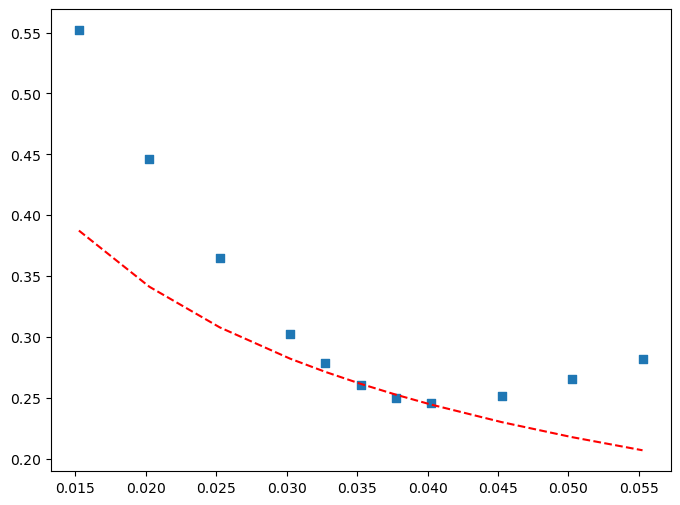

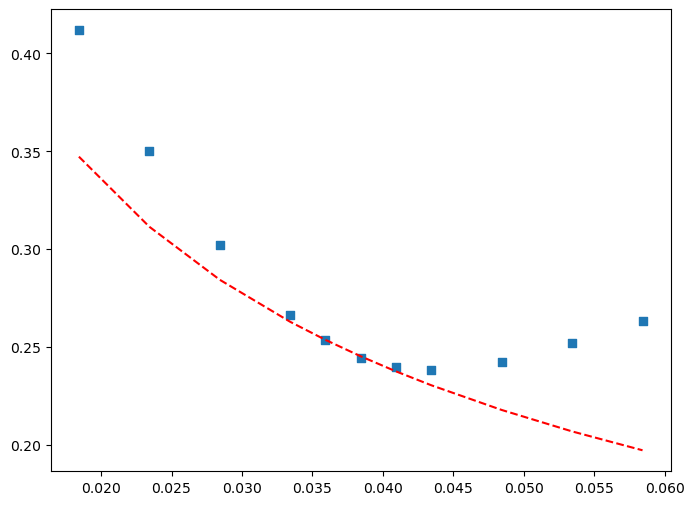

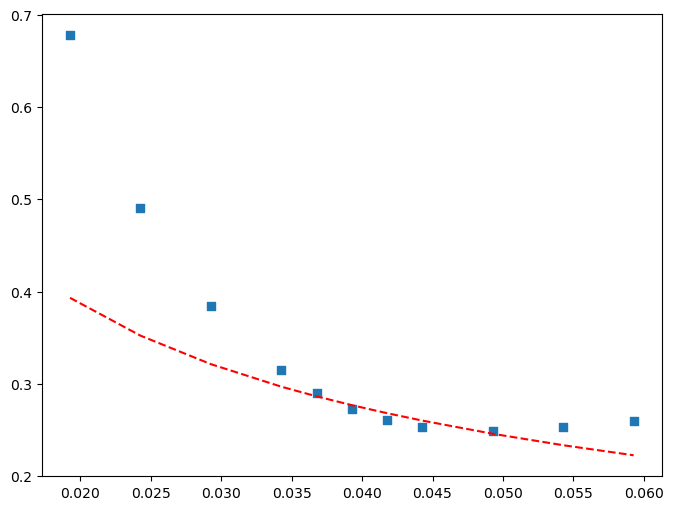

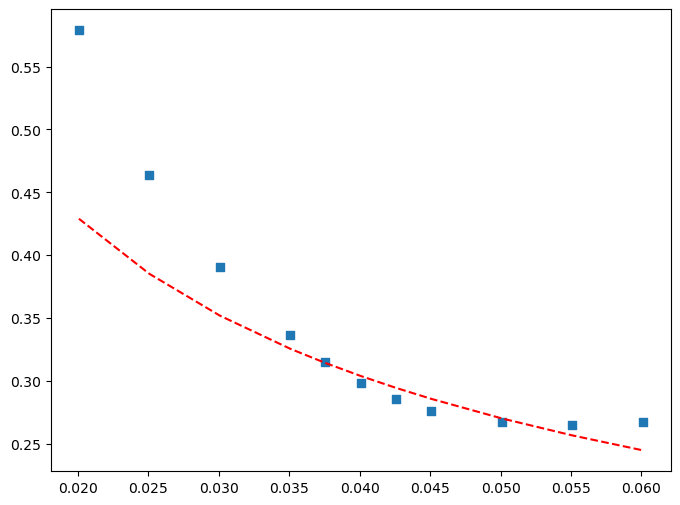

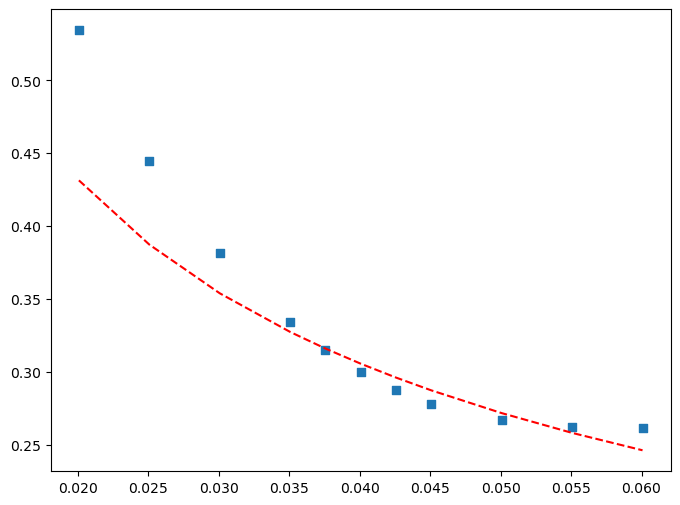

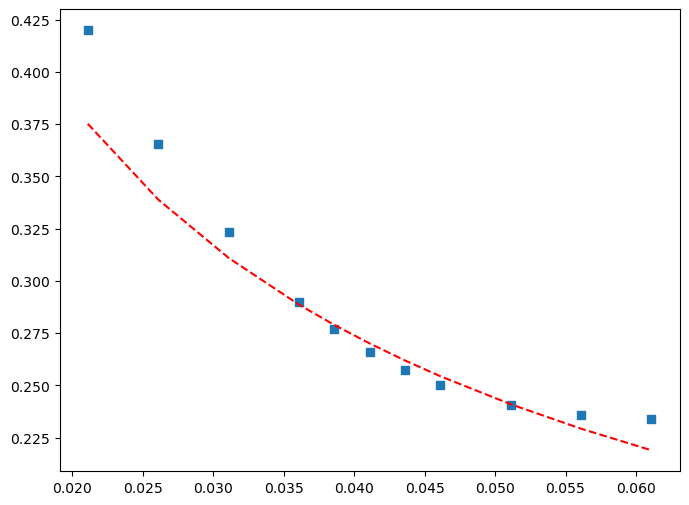

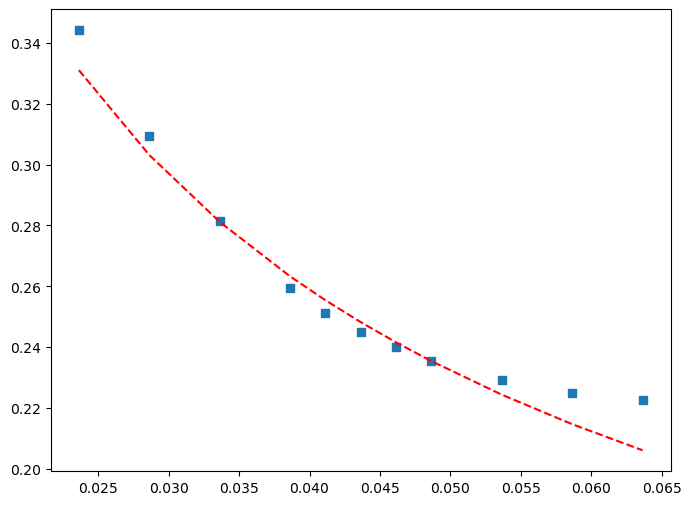

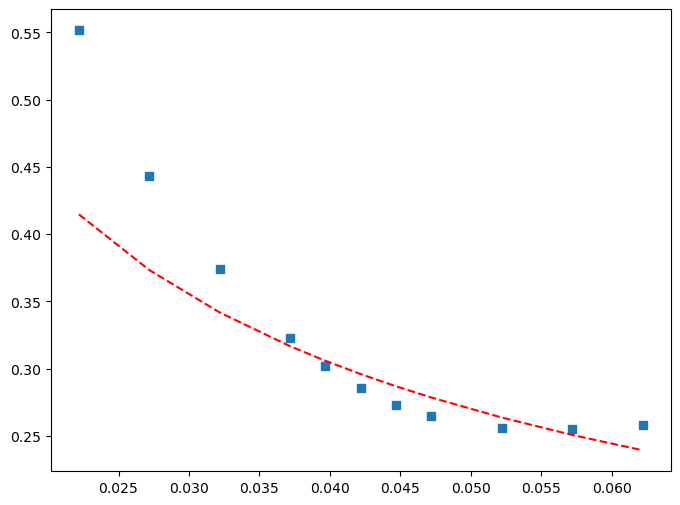

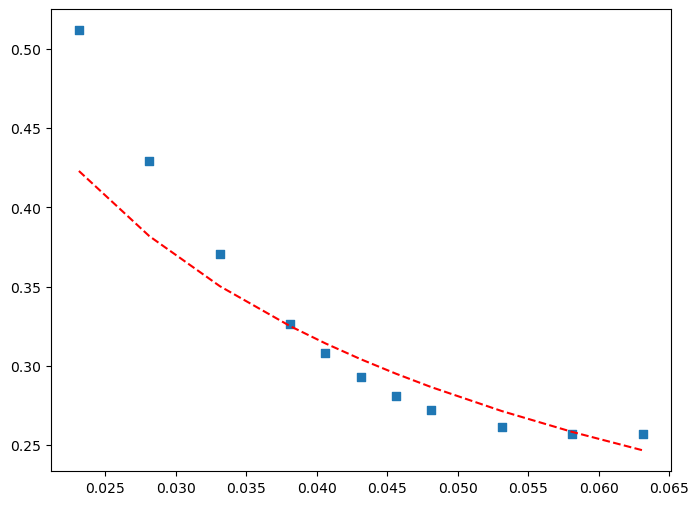

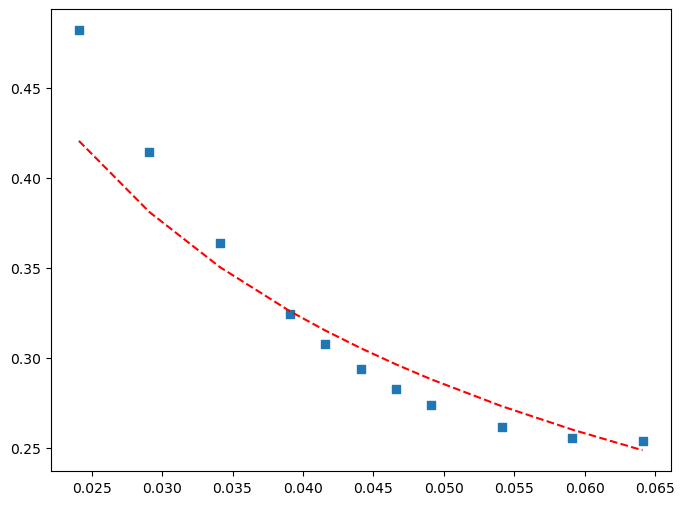

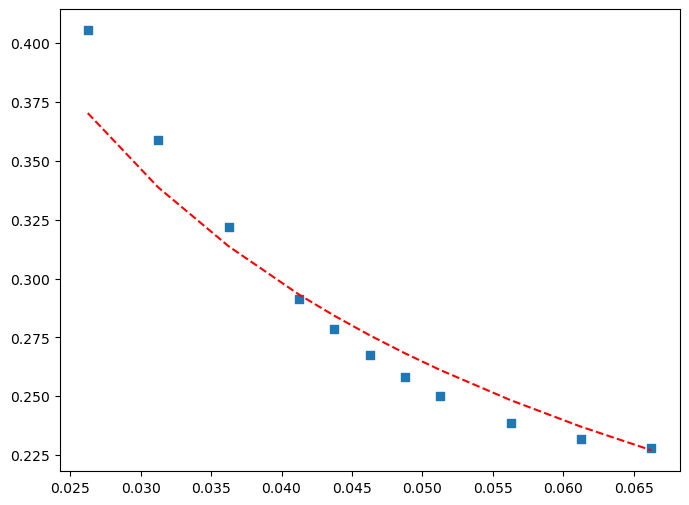

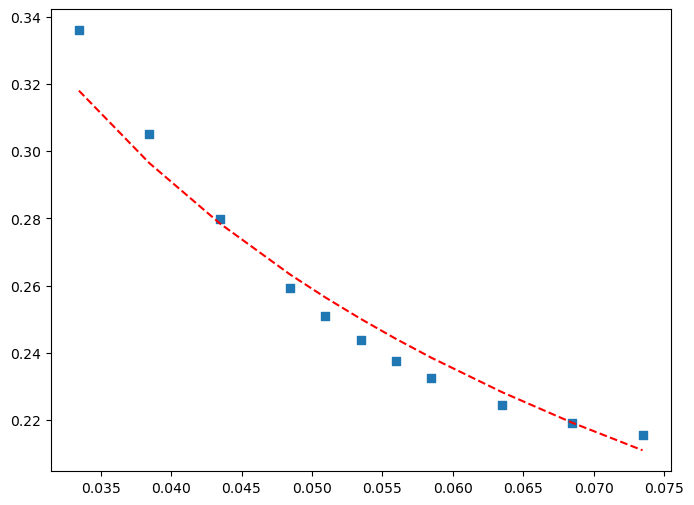

In [28]:
for expiry in expiries:
    for tenor in tenors:
        swap_forward = forward_swap_df.loc[expiry,tenor]
        market_vol = df_swap.loc[(expiry, tenor), :].values
        strikes = swap_forward + bps
        expiry_int = int(expiry.strip()[:-1])
        tenor_int = int(tenor.strip()[:-1])
        disc_factor = 0.5* sum(df_results.Discount_Factor[2*expiry_int:(expiry_int+tenor_int)*2])
        T= expiry_int

        dd_vols_swap = [ImpliedVolatility(swap_forward, i, disc_factor, DD_Sigma.loc[expiry,tenor], T, DD_Beta.loc[expiry,tenor])
                        for i in strikes]


        plt.figure(figsize=(8,6))
        plt.scatter(strikes, market_vol, marker = 's')
        plt.plot(strikes, dd_vols_swap, '--r')


SABR

In [29]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    beta=0.9
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

In [30]:
expiries = ['1Y', '5Y', '10Y']
tenors = ['1Y', '2Y', '3Y', '5Y', '10Y']
sabr_alpha=pd.DataFrame(np.zeros((3,5)), index=expiries,columns=tenors)
sabr_rho=pd.DataFrame(np.zeros((3,5)), index=expiries,columns=tenors)
sabr_nu=pd.DataFrame(np.zeros((3,5)), index=expiries,columns=tenors)

In [31]:
sabr_initial_guess = [0.15, -0.6, 1.3]

for expiry in expiries:
    for tenor in tenors:
        swap_forward = forward_swap_df.loc[expiry,tenor]
        market_vol = df_swap.loc[(expiry, tenor), :].values
        strikes = swap_forward + bps

        expiry_int = int(expiry.strip()[:-1])

        res = least_squares(
            lambda x: sabrcalibration(
                x,
                strikes,
                market_vol,
                swap_forward,
                T= expiry_int
            ),
            sabr_initial_guess,
             bounds=([0.1,-0.75,0.5], [0.2,-0.3, 2.3]),
            xtol=1e-6,  # Looser stopping condition
            ftol=1e-6
        )
        if res.success:
            sabr_alpha.loc[expiry, tenor] = res.x[0]
            sabr_rho.loc[expiry, tenor] = res.x[1]
            sabr_nu.loc[expiry, tenor] = res.x[2]
            print(f"Success: sabr_alpha[{tenor}][{expiry}] = {res.x[0]}, sabr_rho[{tenor}][{expiry}] = {res.x[1]}, sabr_nu[{tenor}][{expiry}] = {res.x[2]}")
        else:
            print(f"Optimization failed for expiry={expiry}, tenor={tenor}")
            print(f"Final error: {sabrcalibration(res.x, strikes, market_vol, swap_forward, T=expiry_int)}")
            print(f"Final parameters: {res.x}")


Success: sabr_alpha[1Y][1Y] = 0.13910357788459593, sabr_rho[1Y][1Y] = -0.6330062548889566, sabr_nu[1Y][1Y] = 2.048783209110644
Success: sabr_alpha[2Y][1Y] = 0.1846425592601795, sabr_rho[2Y][1Y] = -0.5250855973782115, sabr_nu[2Y][1Y] = 1.6773904189357476
Success: sabr_alpha[3Y][1Y] = 0.1967712904214697, sabr_rho[3Y][1Y] = -0.48261711722499534, sabr_nu[3Y][1Y] = 1.438553967961835
Success: sabr_alpha[5Y][1Y] = 0.1779273404887576, sabr_rho[5Y][1Y] = -0.4136425277006885, sabr_nu[5Y][1Y] = 1.0660439103501411
Success: sabr_alpha[10Y][1Y] = 0.17289020122009502, sabr_rho[10Y][1Y] = -0.3097880589022577, sabr_nu[10Y][1Y] = 0.7604156618523644
Success: sabr_alpha[1Y][5Y] = 0.16645452185699788, sabr_rho[1Y][5Y] = -0.5851338342383721, sabr_nu[1Y][5Y] = 1.3398654949497655
Success: sabr_alpha[2Y][5Y] = 0.19838627541201656, sabr_rho[2Y][5Y] = -0.5438848697963986, sabr_nu[2Y][5Y] = 1.062308192887452
Success: sabr_alpha[3Y][5Y] = 0.19995089056668594, sabr_rho[3Y][5Y] = -0.5179597068906967, sabr_nu[3Y][5Y]

In [32]:
sabr_alpha

,1Y,2Y,3Y,5Y,10Y
1Y,0.139104,0.184643,0.196771,0.177927,0.172890
5Y,0.166455,0.198386,0.199951,0.188062,0.171354
10Y,0.178394,0.193247,0.196821,0.192991,0.178947


In [33]:
sabr_rho

,1Y,2Y,3Y,5Y,10Y
1Y,-0.633006,-0.525086,-0.482617,-0.413643,-0.309788
5Y,-0.585134,-0.543885,-0.517960,-0.495742,-0.397162
10Y,-0.548809,-0.540522,-0.527671,-0.540684,-0.512736


In [34]:
sabr_nu

,1Y,2Y,3Y,5Y,10Y
1Y,2.048783,1.677390,1.438554,1.066044,0.760416
5Y,1.339865,1.062308,0.946712,0.683542,0.543337
10Y,1.010698,0.924579,0.860870,0.723664,0.601515


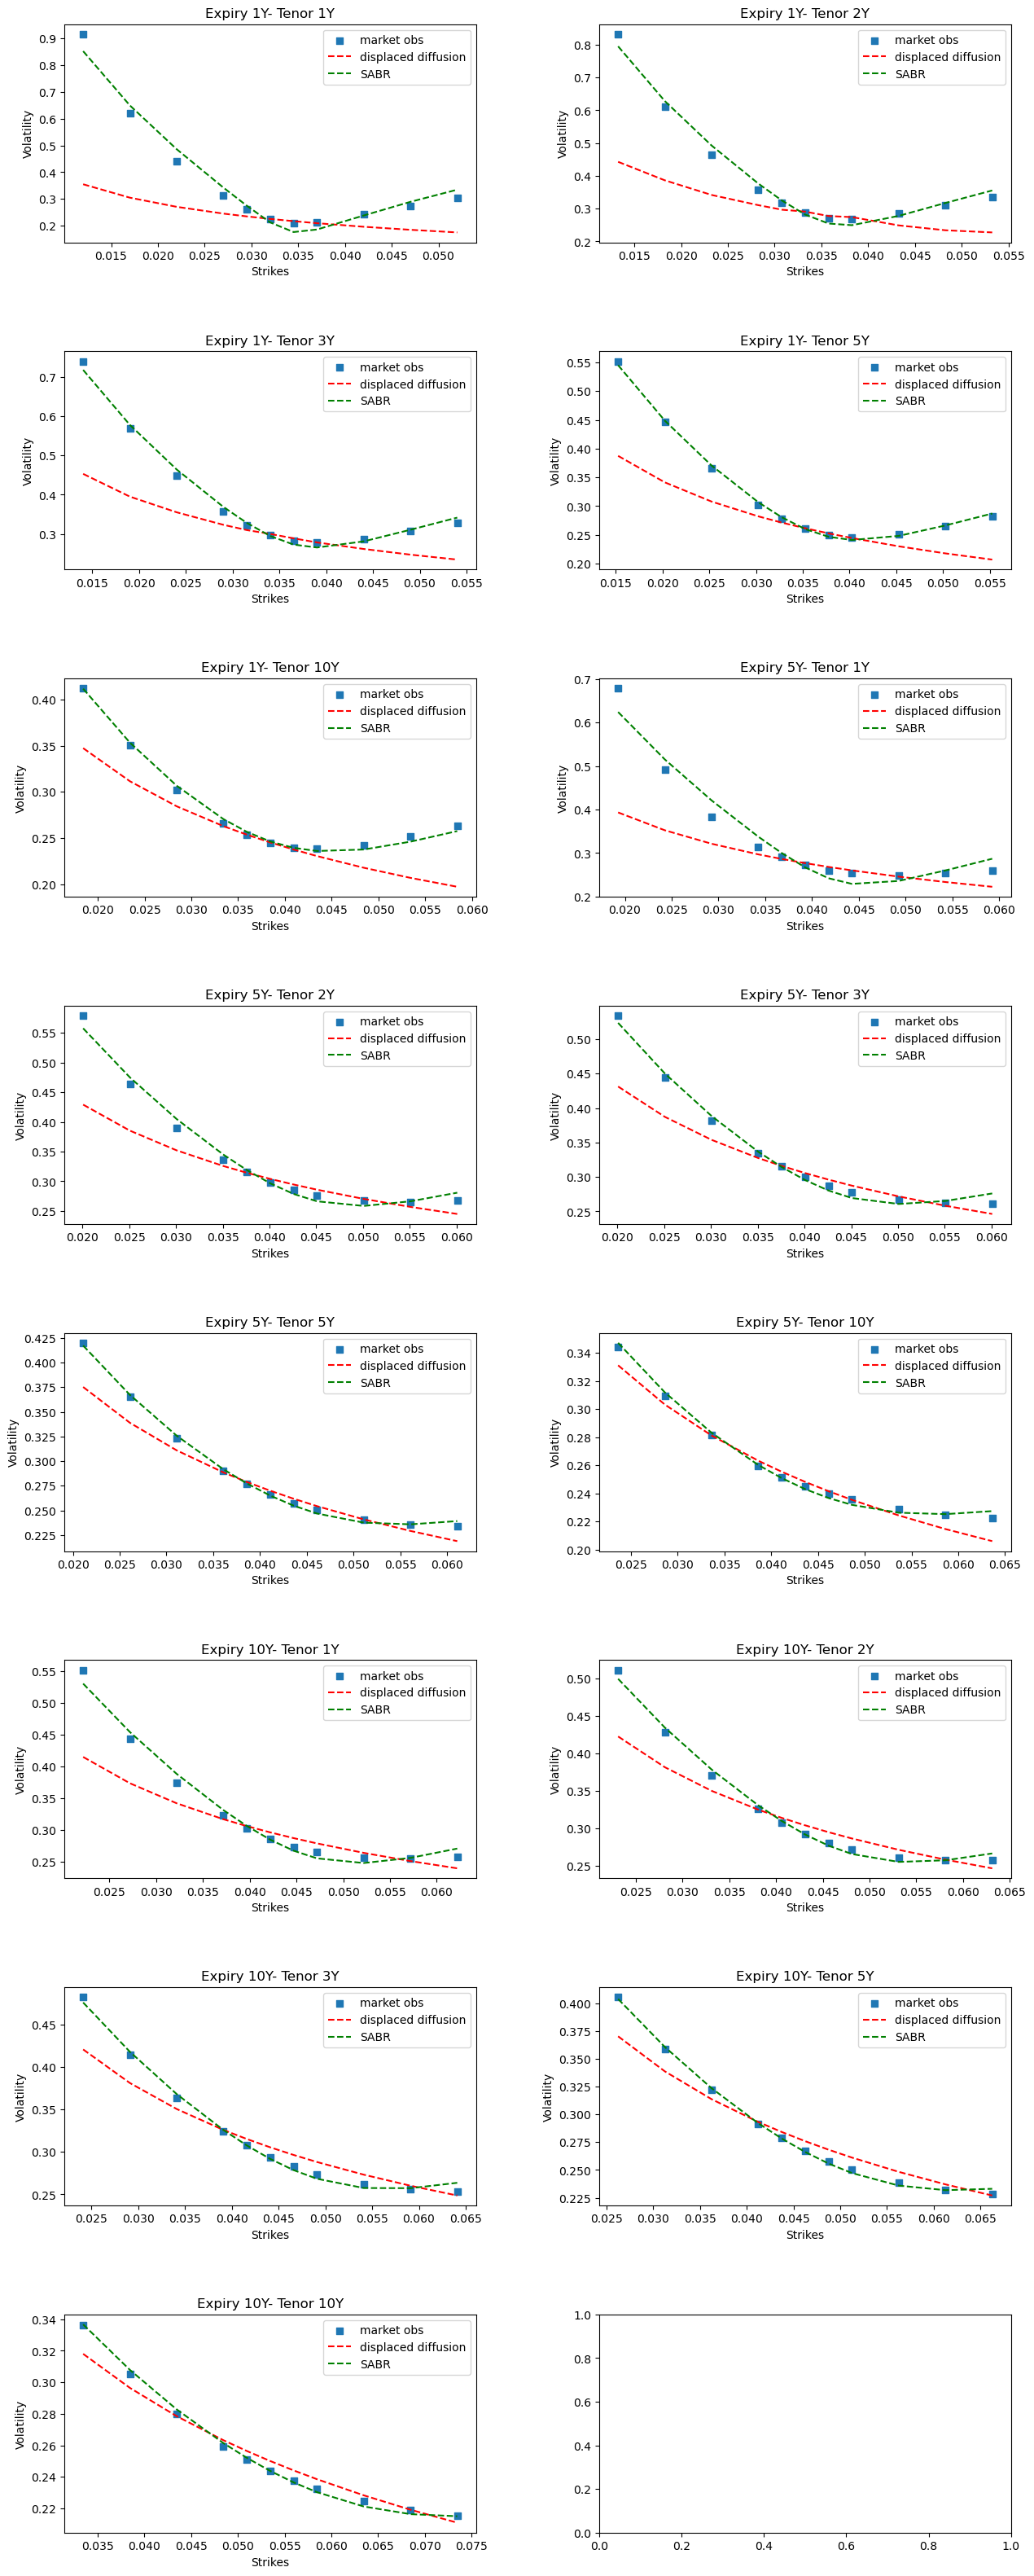

In [35]:
#plot diagrams for DD and SABR
num_plots = len(expiries) * len(tenors)  # 3 * 5 = 15 plots
rows = (num_plots + 1) // 2

fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(15, rows * 5))  # Create a 3x5 grid of subplots
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between plots

axes = axes.flatten()

plot_index = 0

for expiry in expiries:
    for tenor in tenors:
        swap_forward = forward_swap_df.loc[expiry,tenor]
        market_vol = df_swap.loc[(expiry, tenor), :].values
        strikes = swap_forward + bps

        expiry_int = int(expiry.strip()[:-1])
        tenor_int = int(tenor.strip()[:-1])

        disc_factor = 0.5* sum(df_results.Discount_Factor[2*expiry_int:(expiry_int+tenor_int)*2])
        T= expiry_int

        beta = 0.9
        dd_vols_swap = [ImpliedVolatility(swap_forward, i, disc_factor, DD_Sigma.loc[expiry,tenor], T, DD_Beta.loc[expiry,tenor])
                        for i in strikes]

        # def SABR(F, K, T, alpha, beta, rho, nu):
        sabr_vol = [SABR(swap_forward, i, T, sabr_alpha.loc[expiry, tenor], beta, sabr_rho.loc[expiry, tenor], sabr_nu.loc[expiry, tenor])
                   for i in strikes]

        ax = axes[plot_index]
        ax.scatter(strikes, market_vol, marker = 's', label = 'market obs')
        ax.plot(strikes, dd_vols_swap, '--r', label = 'displaced diffusion')
        ax.plot(strikes, sabr_vol, '--g', label = 'SABR')
        ax.set_title(f"Expiry {expiry}- Tenor {tenor}")
        ax.legend()
        ax.set_xlabel("Strikes")
        ax.set_ylabel("Volatility")

        plot_index += 1


Diagrams for SABR + DD

In [43]:
output_path = "data/sabr_calibrated.xlsx"

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    sabr_alpha.to_excel(writer, sheet_name='sabr_alpha')
    sabr_rho.to_excel(writer, sheet_name='sabr_rho')
    sabr_nu.to_excel(writer, sheet_name='sabr_nu')

Part 3: Pricing Swaptions

In [37]:
# Function to interpolate the 10Y tenor from 1Y to 5Y expiry
def interpolate_10y_tenor(df):
    # Extract the 10Y column
    tenors = df.index
    values = df['10Y']

    # Convert the tenors to numerical values for interpolation
    x = np.array([1, 5, 10])  # Corresponding to 1Y, 5Y, 10Y
    y = values.values

    # Create a linear interpolation function
    interp_func = np.interp

    # Generate the interpolated values for 1Y to 10Y
    new_x = np.arange(1, 10.1, 1)  # From 1Y to 10Y in steps of 1Y
    interp_values = interp_func(new_x, x, y)

    # Create a new DataFrame for the interpolated values
    interp_df = pd.DataFrame(interp_values, index=new_x, columns=['10Y'])

    return interp_df

# Apply the function to the various dataFrames
sigma_int = interpolate_10y_tenor(DD_Sigma)
print(sigma_int)
beta_int = interpolate_10y_tenor(DD_Beta)
print(beta_int)
alpha_int = interpolate_10y_tenor(sabr_alpha)
print(alpha_int)
rho_int = interpolate_10y_tenor(sabr_rho)
print(rho_int)
nu_int = interpolate_10y_tenor(sabr_nu)
print(nu_int)

          10Y
1.0   0.24470
2.0   0.24480
3.0   0.24490
4.0   0.24500
5.0   0.24510
6.0   0.24482
7.0   0.24454
8.0   0.24426
9.0   0.24398
10.0  0.24370
           10Y
1.0   0.000007
2.0   0.013871
3.0   0.027734
4.0   0.041598
5.0   0.055462
6.0   0.044719
7.0   0.033975
8.0   0.023232
9.0   0.012488
10.0  0.001745
           10Y
1.0   0.172890
2.0   0.172506
3.0   0.172122
4.0   0.171738
5.0   0.171354
6.0   0.172873
7.0   0.174392
8.0   0.175910
9.0   0.177429
10.0  0.178947
           10Y
1.0  -0.309788
2.0  -0.331632
3.0  -0.353475
4.0  -0.375318
5.0  -0.397162
6.0  -0.420277
7.0  -0.443391
8.0  -0.466506
9.0  -0.489621
10.0 -0.512736
           10Y
1.0   0.760416
2.0   0.706146
3.0   0.651877
4.0   0.597607
5.0   0.543337
6.0   0.554973
7.0   0.566608
8.0   0.578244
9.0   0.589880
10.0  0.601515


In [38]:
# Function to interpolate the 10Y tenor from 1Y to 5Y expiry
def interpolate_10y_tenor(df):
    # Extract the 10Y column
    expiries = df.index
    values = df['10Y']

    # Convert the expiries to numerical values for interpolation
    x = np.array([1, 5, 10])  # Corresponding to 1Y, 5Y, 10Y
    y = values.values

    # Create a linear interpolation function
    interp_func = np.interp

    # Generate the interpolated values for 1Y to 10Y
    new_x = np.arange(1, 10.1, 1)  # From 1Y to 10Y in steps of 1Y
    interp_values = interp_func(new_x, x, y)

    # Create a new DataFrame for the interpolated values
    interp_df = pd.DataFrame(interp_values, index=new_x, columns=['10Y'])
    interp_df.index.name = 'Expiry'

    return interp_df

# Apply the function to the forward_swap_df DataFrame
forward_swapint = interpolate_10y_tenor(forward_swap_df)
print(forward_swapint)

             10Y
Expiry          
1.0     0.038428
2.0     0.039729
3.0     0.041031
4.0     0.042332
5.0     0.043634
6.0     0.045598
7.0     0.047563
8.0     0.049528
9.0     0.051493
10.0    0.053458


In [39]:
strikes=np.arange(0.01,0.081,0.01)
T = 2
expiry_int = 2
tenor_int = 10
two_year_expiry_val = forward_swapint.loc[2.0, '10Y']
sigma_int_val = sigma_int.loc[2.0, '10Y']
beta_int_val = beta_int.loc[2.0, '10Y']
alpha_int_val = alpha_int.loc[2.0, '10Y']
rho_int_val = rho_int.loc[2.0, '10Y']
nu_int_val = nu_int.loc[2.0, '10Y']
disc1 = 0.5 * sum(df_results.Discount_Factor[2*expiry_int:(expiry_int+tenor_int)*2])
print(disc1)

#df_results.Discount_Factor[2*expiry_int:(expiry_int+tenor_int)*2]
payer_dd = [displaceddiffusioncall(two_year_expiry_val, i, disc1, sigma_int_val, T, beta_int_val) for i in strikes]
print(payer_dd)
payer_SABR=[blackscholescall(two_year_expiry_val, i, disc1, SABR(two_year_expiry_val, i, T, alpha_int_val,0.9 ,rho_int_val, nu_int_val), T) for i in strikes]
print(payer_SABR)


9.699554171246167
[0.28906241015262807, 0.19583361365595164, 0.11312506393072304, 0.05192342931410139, 0.01767056635768077, 0.004213396483729455, 0.0006757074765181328, 7.092150734700411e-05]
[0.2905449743741266, 0.19926781451929668, 0.1160581684471574, 0.052489009517516776, 0.02103801460732913, 0.010273480937092972, 0.006201551910025375, 0.004282039254707088]


In [40]:
df_payer = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':payer_dd, 'SABR':payer_SABR})
df_payer

,Strikes,Displaced Diffusion,SABR
0,0.01,0.289062,0.290545
1,0.02,0.195834,0.199268
2,0.03,0.113125,0.116058
3,0.04,0.051923,0.052489
4,0.05,0.017671,0.021038
5,0.06,0.004213,0.010273
6,0.07,0.000676,0.006202
7,0.08,0.000071,0.004282


8X10 year

In [41]:
strikes=np.arange(0.01,0.081,0.01)
T = 8
expiry_int = 8
tenor_int = 10
eight_year_expiry_val = forward_swapint.loc[8.0, '10Y']
print(eight_year_expiry_val)
sigma_int_val = sigma_int.loc[8.0, '10Y']
beta_int_val = beta_int.loc[8.0, '10Y']
alpha_int_val = alpha_int.loc[8.0, '10Y']
rho_int_val = rho_int.loc[8.0, '10Y']
nu_int_val = nu_int.loc[8.0, '10Y']
disc1 = 0.5 * sum(df_results.Discount_Factor[2*expiry_int:(expiry_int+tenor_int)*2])
print(disc1)

#df_results.Discount_Factor[2*expiry_int:(expiry_int+tenor_int)*2]
receiver_dd = [displaceddiffusionput(eight_year_expiry_val, i, disc1, sigma_int_val, T, beta_int_val) for i in strikes]
print(receiver_dd)
receiver_SABR=[blackscholesput(eight_year_expiry_val, i, disc1, SABR(eight_year_expiry_val, i, T, alpha_int_val,0.9 ,rho_int_val, nu_int_val), T) for i in strikes]
print(receiver_SABR)

0.04952797570992568
9.376919874734526
[0.019110796675981534, 0.03385942680231412, 0.05624396741452928, 0.08798483781331276, 0.1302404649883796, 0.18334671379234577, 0.24674675942112642, 0.3191346902351862]
[0.02113432496453353, 0.040619497158574554, 0.06269702673798974, 0.09034764630643023, 0.12843029544868184, 0.1827903984747435, 0.2537279247087987, 0.3351606074840823]


In [42]:
df_receiver = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':receiver_dd, 'SABR':receiver_SABR})
df_receiver

,Strikes,Displaced Diffusion,SABR
0,0.01,0.019111,0.021134
1,0.02,0.033859,0.040619
2,0.03,0.056244,0.062697
3,0.04,0.087985,0.090348
4,0.05,0.130240,0.128430
5,0.06,0.183347,0.182790
6,0.07,0.246747,0.253728
7,0.08,0.319135,0.335161
